In [1]:
import time
!pip install pandas_datareader

import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
#import pandas_datareader as web

import pandas_datareader.data as pdr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#plt.style.use('ggplot')

You are using pip version 9.0.3, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


/srv/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/srv/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
import os
import numpy as np
import pandas as pd
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def get_json_data(json_url, cache_path):
    '''Download and cache JSON data, return as a dataframe.'''
    try:        
        f = open(cache_path, 'rb')
        df = pickle.load(f)   
        print('Loaded {} from cache'.format(json_url))
    except (OSError, IOError) as e:
        print('Downloading {}'.format(json_url))
        df = pd.read_json(json_url)
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(json_url, cache_path))
    return df

In [4]:
base_polo_url = 'https://poloniex.com/public?command=returnChartData&currencyPair={}&start={}&end={}&period={}'
start_date = datetime.strptime('2016-01-01', '%Y-%m-%d') 
end_date = datetime.now() # up until today
period = 86400 # pull daily data (86,400 seconds per day)

def get_crypto_data(poloniex_pair):
    '''Retrieve cryptocurrency data from poloniex'''
    json_url = base_polo_url.format(poloniex_pair, start_date.timestamp(), end_date.timestamp(), period)
    data_df = get_json_data(json_url, poloniex_pair)
    data_df = data_df.set_index('date')
    return data_df

In [5]:
crypto = ['BTC', 'ETH', 'LTC','XRP']

crypto_data = {}
for coin in crypto:
    coinpair = 'USDT_{}'.format(coin)
    crypto_price_df = get_crypto_data(coinpair)
    crypto_data[coin] = crypto_price_df

Loaded https://poloniex.com/public?command=returnChartData&currencyPair=USDT_BTC&start=1451606400.0&end=1535628920.018662&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=USDT_ETH&start=1451606400.0&end=1535628920.018662&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=USDT_LTC&start=1451606400.0&end=1535628920.018662&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=USDT_XRP&start=1451606400.0&end=1535628920.018662&period=86400 from cache


In [6]:
dfp = pd.concat([crypto_data['BTC']['close'],crypto_data['ETH']['close'],crypto_data['LTC']['close'],crypto_data['XRP']['close']], axis=1)

In [9]:
dfp.columns = ['BTC-USD', 'ETH-USD', 'LTC-USD','XRP-USD']
dfp.head()

,BTC-USD,ETH-USD,LTC-USD,XRP-USD
date,,,,
2016-01-01,434.990000,0.959136,3.563049,0.005999
2016-01-02,436.949900,0.957000,3.569990,0.006127
2016-01-03,428.140000,0.960499,3.435230,0.006149
2016-01-04,432.000011,0.962224,3.435230,0.006149
2016-01-05,430.376774,0.939382,3.435234,0.006149


In [14]:
log_return = np.log(dfp/dfp.shift(1))
log_return.head()

,BTC-USD,ETH-USD,LTC-USD,XRP-USD
date,,,,
2016-01-01,NaN,NaN,NaN,NaN
2016-01-02,0.004496,-0.002229,0.001946,0.021075
2016-01-03,-0.020368,0.003650,-0.038479,0.003695
2016-01-04,0.008975,0.001794,0.000000,0.000000
2016-01-05,-0.003765,-0.024024,0.000001,0.000000


In [15]:
log_return.mean() * len(log_return)

BTC-USD    2.769979
ETH-USD    5.679873
LTC-USD    2.820875
XRP-USD    4.012676
dtype: float64

In [16]:
log_return.cov() * len(log_return)

,BTC-USD,ETH-USD,LTC-USD,XRP-USD
BTC-USD,1.737306,1.090603,1.478987,0.972525
ETH-USD,1.090603,4.432073,1.532731,1.404765
LTC-USD,1.478987,1.532731,3.744821,1.834766
XRP-USD,0.972525,1.404765,1.834766,7.101602


You are using pip version 9.0.3, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


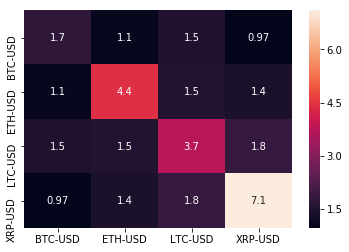

In [21]:
!pip install seaborn
import seaborn as sns
sns.heatmap(log_return.cov() * len(log_return),annot=True)

In [31]:
np.random.seed(101)
num_of_ite = 50000
all_weights = np.zeros((num_of_ite,len(dfp.columns)))
port_return = np.zeros(num_of_ite)
port_vol = np.zeros(num_of_ite)
sharpe_ratio = np.zeros(num_of_ite)

for i in range(num_of_ite):
    weights = np.array(np.random.random(4))
    weights = weights / np.sum(weights)
    all_weights[i,:] = weights
    port_return[i] = np.sum((log_return.mean() * weights) *len(log_return))
    port_vol[i] = np.sqrt(np.dot(weights.T, np.dot(log_return.cov() * len(log_return), weights)))
    sharpe_ratio[i] = port_return[i]/port_vol[i]

In [32]:
sharpe_ratio.max()

2.99279615133353

In [33]:
sharpe_ratio.argmax()

12662

In [34]:
all_weights [12662,:]

array([0.36648815, 0.50543655, 0.00578541, 0.12228988])

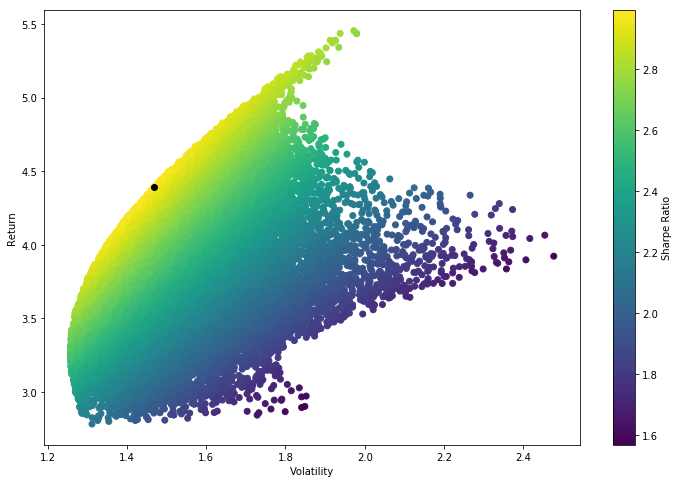

In [36]:
max_port_return = port_return[12662]
max_port_vol = port_vol[12662]

plt.figure(figsize=(12,8))
plt.scatter(x=port_vol,y=port_return,c=sharpe_ratio)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(x=max_port_vol,y=max_port_return,c='black')

In [37]:
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(log_return.mean() * weights) * len(log_return)
    vol = np.sqrt(np.dot(weights.T, np.dot(log_return.cov() * len(log_return), weights)))
    sr = ret/vol
    return np.array([ret,vol,sr])

In [38]:
def neg_sharpe(weights):
    return  get_ret_vol_sr(weights)[2] * -1

In [39]:
def check_sum(weights):
    return np.sum(weights) - 1

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
%matplotlib inline

In [42]:
cons = ({'type':'eq','fun': check_sum})
bounds = ((0, 1), (0, 1), (0, 1), (0, 1))
init_guess = [0.25,0.25,0.25,0.25]
opt_results = minimize(neg_sharpe,init_guess,method='SLSQP',bounds=bounds,constraints=cons)

In [43]:
opt_results

     fun: -2.9958767573081975
     jac: array([-4.58657742e-05,  7.45058060e-06,  2.74987608e-01,  1.19596720e-04])
 message: 'Optimization terminated successfully.'
    nfev: 43
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([0.39728835, 0.48015277, 0.        , 0.12255888])

In [44]:
opt_results.x

array([0.39728835, 0.48015277, 0.        , 0.12255888])

In [46]:
get_ret_vol_sr(opt_results.x)

array([4.31947619, 1.44180704, 2.99587676])